In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_log_error,mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [6]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [7]:
#load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [87]:
ss.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [8]:
#additional df
oils = pd.read_csv('oil.csv')
transactions = pd.read_csv('transactions.csv')
holidays_events = pd.read_csv('holidays_events.csv')
stores = pd.read_csv('stores.csv')

In [65]:
oils.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [9]:
df_data =  train.copy()
df_data = df_data.merge(stores, how="left", on='store_nbr')   
df_data = df_data.merge(oils, how="left", on='date')      
df_data = df_data.merge(transactions, how="left", on=['date','store_nbr'])  
df_data = df_data.merge(holidays_events,on='date',how='left')
df_data = df_data.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data.date = pd.to_datetime(df_data.date)
df_data['year'] = df_data['date'].dt.year
df_data['month'] = df_data['date'].dt.month
df_data['week'] = df_data['date'].dt.isocalendar().week
df_data['quarter'] = df_data['date'].dt.quarter
df_data['day_of_week'] = df_data['date'].dt.day_name()
df_data.head()

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  store_type  cluster  ...  holiday_type    locale locale_name  \
0          D       13  ...       Holiday  National     Ecuador   
1          D       13  ...       Holiday  National     Ecuador   
2          D       13  ...       Holiday  National     Ecuador   
3          D       13  ...       Holiday  National     Ecuador   
4          D       13  ...       Holiday  National     Ecuador   

          description transferred  year month  week  quarter  day_of_week  
0  Primer dia del ano       False  2013     1     1        1      Tuesday  
1  Primer dia del ano       False  2013     1     1        1      Tuesday  
2  Primer dia del ano       False  2013     1     1        1      Tuesday  
3  Primer dia del ano       False  2013     1     1        1      Tuesday  
4  Primer dia del ano       False  2013     1     1        1      Tuesday  

[5 rows x 22 columns]

In [49]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    #.loc['2017']
)

In [63]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    plt.rcParams['figure.figsize']=(12,8)
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

/var/folders/tj/l3ds5s01189b1cb8qdl0kps80000gn/T/ipykernel_73329/841079489.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(average_sales)


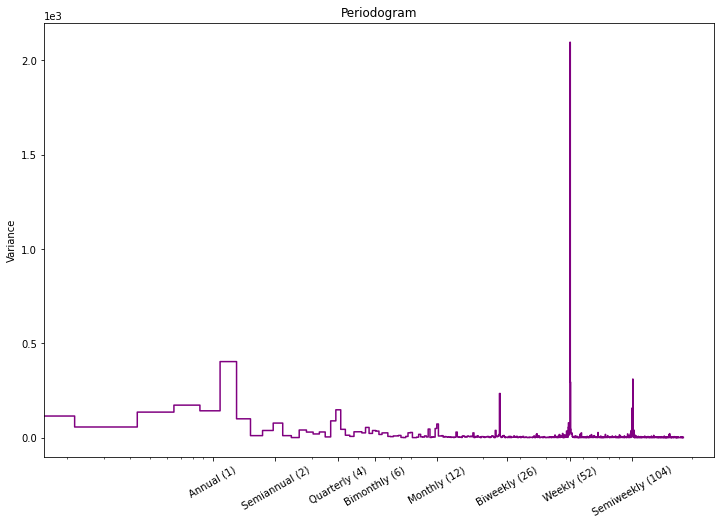

In [64]:
plot_periodogram(average_sales)

Text(0.5, 0, 'Date')

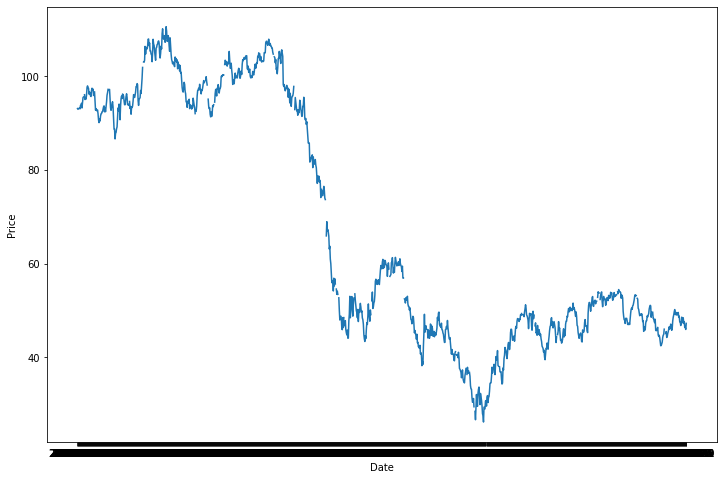

In [66]:
plt.plot(oils['date'],oils['dcoilwtico'])
plt.title="Daily oil price!"
plt.ylabel("Price")
plt.xlabel("Date")

In [10]:
#TEST

df_data_test =  test.copy()
df_data_test = df_data_test.merge(stores, how="left", on='store_nbr')   
df_data_test = df_data_test.merge(oils, how="left", on='date')      
df_data_test = df_data_test.merge(transactions, how="left", on=['date','store_nbr'])  
df_data_test = df_data_test.merge(holidays_events,on='date',how='left')
df_data_test = df_data_test.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

df_data_test.date = pd.to_datetime(df_data_test.date)
df_data_test['year'] = df_data_test['date'].dt.year
df_data_test['month'] = df_data_test['date'].dt.month
df_data_test['week'] = df_data_test['date'].dt.isocalendar().week
df_data_test['quarter'] = df_data_test['date'].dt.quarter
df_data_test['day_of_week'] = df_data_test['date'].dt.day_name()
df_data_test.head()

id       date  store_nbr      family  onpromotion   city      state  \
0  3000888 2017-08-16          1  AUTOMOTIVE            0  Quito  Pichincha   
1  3000889 2017-08-16          1   BABY CARE            0  Quito  Pichincha   
2  3000890 2017-08-16          1      BEAUTY            2  Quito  Pichincha   
3  3000891 2017-08-16          1   BEVERAGES           20  Quito  Pichincha   
4  3000892 2017-08-16          1       BOOKS            0  Quito  Pichincha   

  store_type  cluster  dcoilwtico  ...  holiday_type locale locale_name  \
0          D       13        46.8  ...           NaN    NaN         NaN   
1          D       13        46.8  ...           NaN    NaN         NaN   
2          D       13        46.8  ...           NaN    NaN         NaN   
3          D       13        46.8  ...           NaN    NaN         NaN   
4          D       13        46.8  ...           NaN    NaN         NaN   

  description transferred  year  month  week  quarter  day_of_week  
0         NaN         NaN  2017      8    33        3    Wednesday  
1         NaN         NaN  2017      8    33        3    Wednesday  
2         NaN         NaN  2017      8    33        3    Wednesday  
3         NaN         NaN  2017      8    33        3    Wednesday  
4         NaN         NaN  2017      8    33        3    Wednesday  

[5 rows x 21 columns]

In [11]:
df_data.transactions = df_data.transactions.replace(np.nan,0)
#test
df_data_test.transactions = df_data_test.transactions.replace(np.nan,0)

In [12]:
df_data[['locale','locale_name', 'description']] = df_data[['locale','locale_name', 'description']].replace(np.nan,'')
df_data['holiday_type'] = df_data['holiday_type'].replace(np.nan,'Working Day')
df_data['transferred'] = df_data['transferred'].replace(np.nan,False)

#test
df_data_test[['locale','locale_name', 'description']] = df_data_test[['locale','locale_name', 'description']].replace(np.nan,'')
df_data_test['holiday_type'] = df_data_test['holiday_type'].replace(np.nan,'Working Day')
df_data_test['transferred'] = df_data_test['transferred'].replace(np.nan,False)

In [13]:
df_data['dcoilwtico'] = df_data['dcoilwtico'].fillna(method='bfill')

df_data_test['dcoilwtico'] = df_data_test['dcoilwtico'].fillna(method='bfill')

In [14]:
df_data.drop(columns = ['id'],inplace=True)

df_data_test.drop(columns = ['id'],inplace=True)

In [48]:
df_data.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'store_type', 'cluster', 'dcoilwtico', 'transactions', 'holiday_type',
       'locale', 'locale_name', 'transferred', 'year', 'month', 'week',
       'quarter', 'day_of_week'],
      dtype='object')

In [16]:
family_list = df_data['family'].unique()
family_list

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [17]:
df_data.drop(columns=['date','description'],inplace=True)
df_data_test.drop(columns=['date','description'],inplace=True)

In [18]:
y=df_data['sales']

In [19]:
features = ['store_nbr', 'family',  'onpromotion', 'city', 'state',
       'store_type', 'cluster', 'dcoilwtico', 'transactions', 'holiday_type',
       'locale', 'locale_name', 'transferred', 'year', 'month',
       'week', 'quarter', 'day_of_week']

In [20]:
cat_cols = ['city','state','store_type','cluster','holiday_type','locale','locale_name','year','month','week','quarter','day_of_week']

In [21]:
ohe = OneHotEncoder()
transformed_data = ohe.fit_transform(df_data[cat_cols])

In [28]:
transformed_data_test = ohe.transform(df_data_test[cat_cols])

In [29]:
transformed_df = pd.DataFrame(transformed_data.todense())
transformed_df_test = pd.DataFrame(transformed_data_test.todense())

In [30]:
col = ['family','store_nbr','sales']
col_test = ['family','store_nbr']

In [31]:
final_train_data = pd.concat([transformed_df,df_data[col]],axis=1)
final_train_data_test = pd.concat([transformed_df_test,df_data_test[col_test]],axis=1)

In [32]:
final_train_data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Columns: 179 entries, 0 to store_nbr
dtypes: float64(177), int64(1), object(1)
memory usage: 38.9+ MB


In [33]:
groups = final_train_data.groupby(['family','store_nbr'])
data= [groups.get_group(x) for x in groups.groups]

In [34]:
family_store_nbr_df = groups.size().reset_index().rename(columns={0:'count'})

In [35]:
family_store_nbr_df

family  store_nbr  count
0     AUTOMOTIVE          1   1714
1     AUTOMOTIVE          2   1714
2     AUTOMOTIVE          3   1714
3     AUTOMOTIVE          4   1714
4     AUTOMOTIVE          5   1714
...          ...        ...    ...
1777     SEAFOOD         50   1714
1778     SEAFOOD         51   1714
1779     SEAFOOD         52   1714
1780     SEAFOOD         53   1714
1781     SEAFOOD         54   1714

[1782 rows x 3 columns]

In [39]:
f_list = final_train_data.columns
f_list[:-3]

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176],
      dtype='object', length=177)

In [40]:
final_train_data_test.columns

Index([          0,           1,           2,           3,           4,
                 5,           6,           7,           8,           9,
       ...
               169,         170,         171,         172,         173,
               174,         175,         176,    'family', 'store_nbr'],
      dtype='object', length=179)

In [47]:
models =[]
for i in range(len(data)):
    m = LGBMRegressor()
    m.fit(data[i][f_list[:-3]],data[i]['sales'])
    models.append(m)

In [ ]:
#predict
y_pred =[]

for index, row in final_train_data_test.iterrows():
    i = family_store_nbr_df.index[(family_store_nbr_df['family'] == row['family']) & (family_store_nbr_df['store_nbr'] == row['store_nbr'])].tolist()[0]
    y_pred.append(models[i].predict(np.array(row[:-2]).reshape( 1,-1))[0])


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
172    0.0
173    0.0
174    0.0
175    0.0
176    1.0
Name: 0, Length: 177, dtype: object
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
172    0.0
173    0.0
174    0.0
175    0.0
176    1.0
Name: 1, Length: 177, dtype: object
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
172    0.0
173    0.0
174    0.0
175    0.0
176    1.0
Name: 2, Length: 177, dtype: object
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
172    0.0
173    0.0
174    0.0
175    0.0
176    1.0
Name: 3, Length: 177, dtype: object
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
172    0.0
173    0.0
174    0.0
175    0.0
176    1.0
Name: 4, Length: 177, dtype: object
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
172    0.0
173    0.0
174    0.0
175    0.0
176    1.0
Name: 5, Length: 177, dtype: object
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
   

In [88]:
ss['sales']=y_pred
ss.to_csv("first_submission.csv",index=False)


In [86]:
y_pred

[4.767224934167291,
 0.0,
 4.030398656942134,
 2426.955330709475,
 0.2379492541262585,
 408.41464737458415,
 12.787940938470939,
 807.8031644842181,
 851.5341063781981,
 136.03023157097252,
 152.09095986276265,
 145.2661718429173,
 3015.7591612129154,
 26.83214019192129,
 1.5373194755112118,
 33.05375414913128,
 26.7673326951834,
 -0.02673523830623544,
 204.36914773464133,
 15.915068667401945,
 24.14752567951658,
 9.591382950526308,
 91.11071899773654,
 6.771147015614866,
 282.3463926941149,
 182.21987618315126,
 3.8923335806951638,
 10.858412760220823,
 336.9919866499131,
 67.78012349687185,
 3961.9165921703493,
 0.08849379919461399,
 25.36135918797175,
 1.4724862366630767,
 -0.018270736935956232,
 2.01592465890228,
 1290.9042825440447,
 0.0,
 78.98302454544331,
 3.2065910893396117,
 565.1978316525295,
 398.0475599607462,
 245.1946860392287,
 41.52831707352121,
 32.399653117043314,
 2339.6137104179056,
 4.880858654692295,
 0.2729079934530546,
 9.507101627797907,
 7.170722484619482,
 0

In [26]:
models

[LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegressor(),
 LGBMRegre